### Description: Sparse Bayesian learning, original method by Tipping
#### Assumptions: scalar input, scalar output

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys

Assign polynomial basis (polyPower), hyper-parameters a,b,c,d and initial hyperparameter $\alpha$ and noise precision $\rho$:

In [2]:
polyPower = [0,1,2,3,4,5] # powers of polynomial basis
N = len(polyPower) # number of coefficients 
rho0 = 30 # initial error precision
alpha0 = [1e-03]*N # initial hyperparameter vector
Wlim = [-6,6]
Nsbl = 25
a=c=1.05
b=d=0.000001
SBLapproach = 2
mpl.rcParams.update({'font.size':14})

In [3]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = Xobs[i]**polyPower[j]

In [4]:
def updatemPevid(alphai,rhoi):
    Ai = np.diag(alphai)
    Pcondi = np.linalg.cond(Ai + rhoi*np.matmul(np.transpose(Phi),Phi))
    Pi = np.linalg.inv(Ai + rhoi*np.matmul(np.transpose(Phi),Phi))
    mi = rhoi*np.matmul(Pi,np.matmul(np.transpose(Phi),Yobs))
    Bi = np.matmul(Phi,np.matmul(np.linalg.inv(Ai),np.transpose(Phi))) + np.identity(M)/rhoi
    evidi = st.multivariate_normal.pdf(Yobs,[0]*M,Bi)
    return mi, Pi, evidi, Pcondi

In [5]:
Ngrid = 1000
Wpost = np.zeros((N,Ngrid))
Wprior = np.zeros((N,Ngrid))
Wgrid = np.zeros((N,Ngrid))
alpha = np.zeros((N,Nsbl))
gamma = np.zeros((N,Nsbl))
Wvar = np.zeros((N,Nsbl))
Wmu = np.zeros((N,Nsbl))
KLdis = np.zeros((N,Nsbl))
KLdist = np.zeros((N,Nsbl))
evid = [0]*Nsbl
gof = [0]*Nsbl
Pcond = [0]*Nsbl
rho = [0]*Nsbl
P = np.zeros((N,N))
alpha[:,0] = alpha0;
rho[0] = rho0;
for j in range(0,Nsbl-1):
    Wmu[:,j],P,evid[j],Pcond[j] = updatemPevid(alpha[:,j],rho[j])
    Wvar[:,j] = np.diag(P)
    gof[j] = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,Wmu[:,j]),np.identity(M)/rho[j])
    for i in range(0,N):
        gamma[i,j]   = 1-alpha[i,j]*Wvar[i,j] 
        KLdist[i,j] = 0.5*(-np.log(alpha[i,j]*Wvar[i,j])- 1 + alpha[i,j]*(Wvar[i,j] + Wmu[i,j]**2))
        if SBLapproach == 1:
            alpha[i,j+1] = (1+2*(c-1))/(Wvar[i,j] + Wmu[i,j]**2+2*d)
            rho[j+1] = (M+2*(a-1))/(np.power(np.linalg.norm(Yobs-np.matmul(Phi,Wmu[:,j])),2)\
                            +np.trace(np.matmul(P,np.matmul(np.transpose(Phi),Phi)))+2*b)
        else:
            alpha[i,j+1] = (gamma[i,j]+2*(c-1))/(Wmu[i,j]**2+2*d)
            rho[j+1] = (M-np.sum(gamma[:,j])+2*(a-1))/(np.power(np.linalg.norm(Yobs-np.matmul(Phi,Wmu[:,j])),2)+2*b)
        if j == (Nsbl-2):
            Wgrid[i,:] = np.linspace(Wlim[0],Wlim[1],Ngrid)
            Wpost[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],Wmu[i,j],Wvar[i,j])
            Wprior[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],0,1/alpha[i,j])
            #KLdis[i,j] = st.entropy(Wpost[i,:],Wprior[i,:]) 
    #print(alpha[:,j],rho[j], np.log(evid[j]),gof[j])

## Plotting for SBL iteration

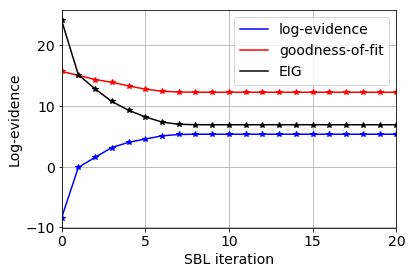

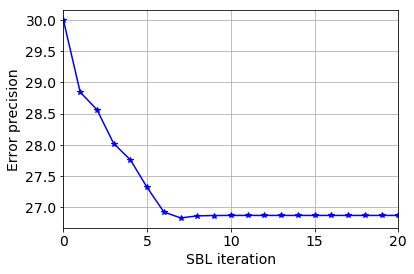

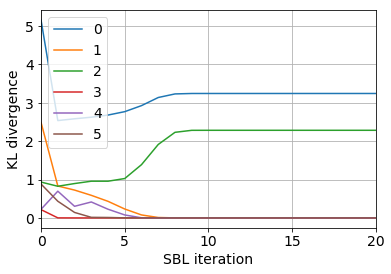

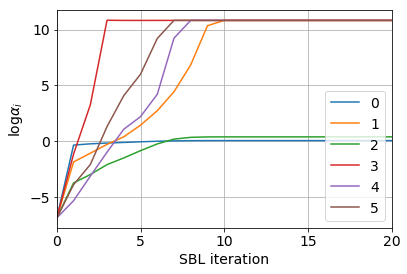

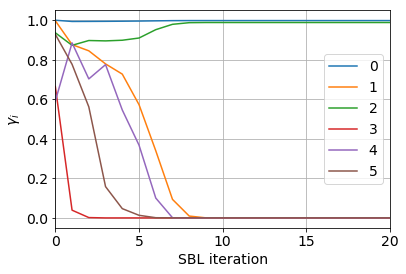

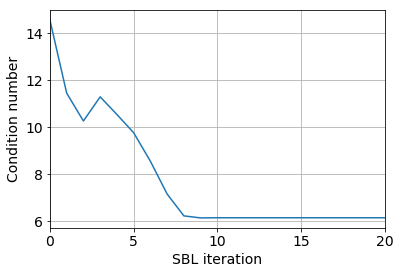

In [6]:
# plt.figure(1)
# plt.plot(np.log(evid[:-1]),'b*')
# plt.plot(np.log(evid[:-1]),'b-')
# plt.grid(True)
# plt.ylabel('Log-evidence')
# plt.xlabel('SBL iteration')
# plt.xlim([0,Nsbl-5])
# plt.savefig('SBL1_EVID.eps',bbox_inches='tight')
# plt.figure(2)
# plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'b*')
# plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'b-')
# plt.grid(True)
# plt.xlim([0,Nsbl-5])
# plt.ylabel('EIG')
# plt.xlabel('SBL iteration'); 
# plt.savefig('SBL1_EIG.eps',bbox_inches='tight')
# plt.figure(3)
# plt.plot(np.log(gof[:-1]),'b*')
# plt.plot(np.log(gof[:-1]),'b-')
# plt.grid(True)
# plt.xlim([0,Nsbl-5])
# plt.ylabel('Goodness-of-fit')
# plt.xlabel('SBL iteration');
# plt.savefig('SBL1_GOF.eps',bbox_inches='tight')
plt.figure(4)
plt.plot(np.log(evid[:-1]),'b*')
plt.plot(np.log(evid[:-1]),'b-',label='log-evidence')
plt.plot(np.log(gof[:-1]),'r*')
plt.plot(np.log(gof[:-1]),'r-',label='goodness-of-fit')
plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'k*')
plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'k-',label='EIG')
plt.grid(True)
plt.legend(loc='best', numpoints = 1);
plt.ylabel('Log-evidence')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('SBL1_EVIDALL.eps',bbox_inches='tight')
plt.figure(5)
plt.plot(rho[:-1],'b*')
plt.plot(rho[:-1],'b-')
plt.grid(True)
plt.xlim([0,Nsbl-5])
plt.ylabel('Error precision')
plt.xlabel('SBL iteration');
plt.savefig('SBL1_RHO.eps',bbox_inches='tight')
plt.figure(6)
for i in range(0,N):
    plt.plot(KLdist[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel('KL divergence')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='best', numpoints = 1);
plt.savefig('SBL1_KLDIV.eps',bbox_inches='tight')
plt.figure(7)
for i in range(0,N):
    plt.plot(np.log(alpha[i,:-1]),label=str(i))
plt.grid(True)
plt.ylabel(r'$\log\alpha_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='best', numpoints = 1);
plt.savefig('SBL1_ALPHA.eps',bbox_inches='tight')
plt.figure(8)
for i in range(0,N):
    plt.plot(gamma[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel(r'$\gamma_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='best', numpoints = 1);
plt.savefig('SBL1_GAMMA.eps',bbox_inches='tight')
plt.figure(91)
plt.plot(np.log(Pcond[:-1]))
plt.grid(True)
plt.ylabel('Condition number')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('SBL1_Pcond.eps',bbox_inches='tight')

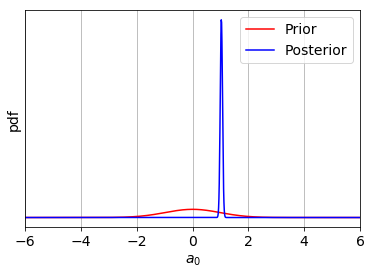

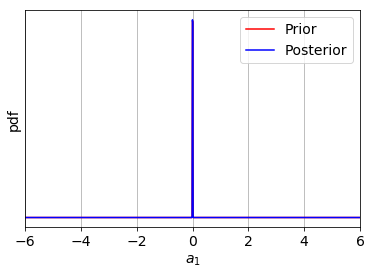

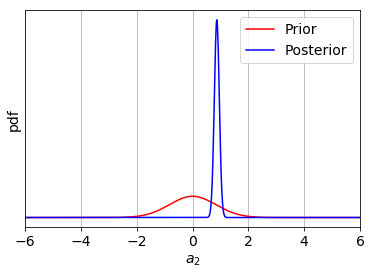

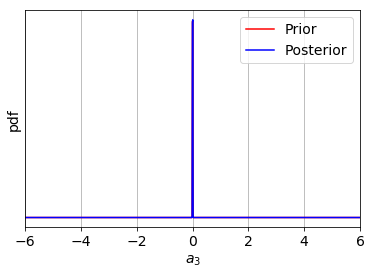

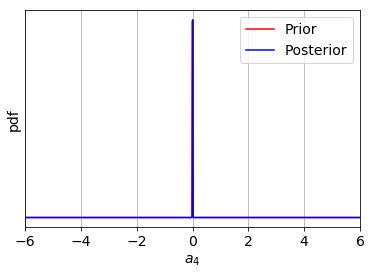

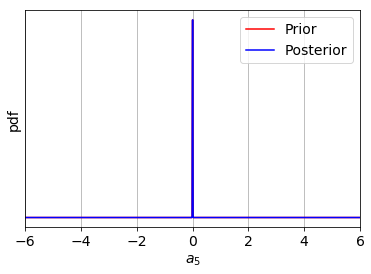

In [7]:
for i in range(0,N):
    fig = plt.figure(+i)
    plt.plot(Wgrid[i,:],Wprior[i,:],'r-',label='Prior')
    plt.plot(Wgrid[i,:],Wpost[i,:],'b-',label='Posterior')
    plt.yticks([])
    plt.grid(True)
    plt.xlabel(r'$a_'+str(i)+'$')
    plt.ylabel('pdf')
    #plt.xlim(Wrange[i,:])
    plt.xlim(Wlim[0],Wlim[1])
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('SBL1_PDF_W'+str(i)+'.eps',bbox_inches='tight')

In [8]:
def fn(X):
    return np.polyval([1,0,1],X)
newbasis = [1,0,1,0,0,0]
Mnew = 100
Xrnge = [-2,2]
Yrnge = [-2,10]

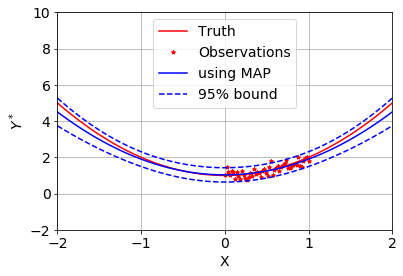

In [9]:
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = newbasis[j]*Xnew[i]**polyPower[j]
PredVar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho[Nsbl-2]
PredMean = np.matmul(PhiNew,Wmu[:,Nsbl-2])
Ytrue = fn(Xnew)
fig = plt.figure(N+10)
plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.plot(Xobs,Yobs,'r*',label='Observations',markersize=4)
plt.plot(Xnew,PredMean,'b-',label='using MAP')
plt.plot(Xnew,PredMean+2*np.sqrt(np.diag(PredVar)),'b--',label='95% bound')
plt.plot(Xnew,PredMean-2*np.sqrt(np.diag(PredVar)),'b--')
plt.grid(True)
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
plt.legend(loc='best', numpoints = 1)
plt.savefig('SBL1_PRED.eps',bbox_inches='tight')
